Bayesian Linear Regression: Hand Calculation Visualization
Design matrix Φ:
[[1 0]
 [1 1]]

ΦᵀΦ:
[[2 1]
 [1 1]]

S⁻¹ = S₀⁻¹ + βΦᵀΦ:
[[9. 4.]
 [4. 5.]]

Posterior covariance S:
[[ 0.17241379 -0.13793103]
 [-0.13793103  0.31034483]]

Φᵀy:
[4 3]

Posterior mean m:
[1.10344828 1.51724138]


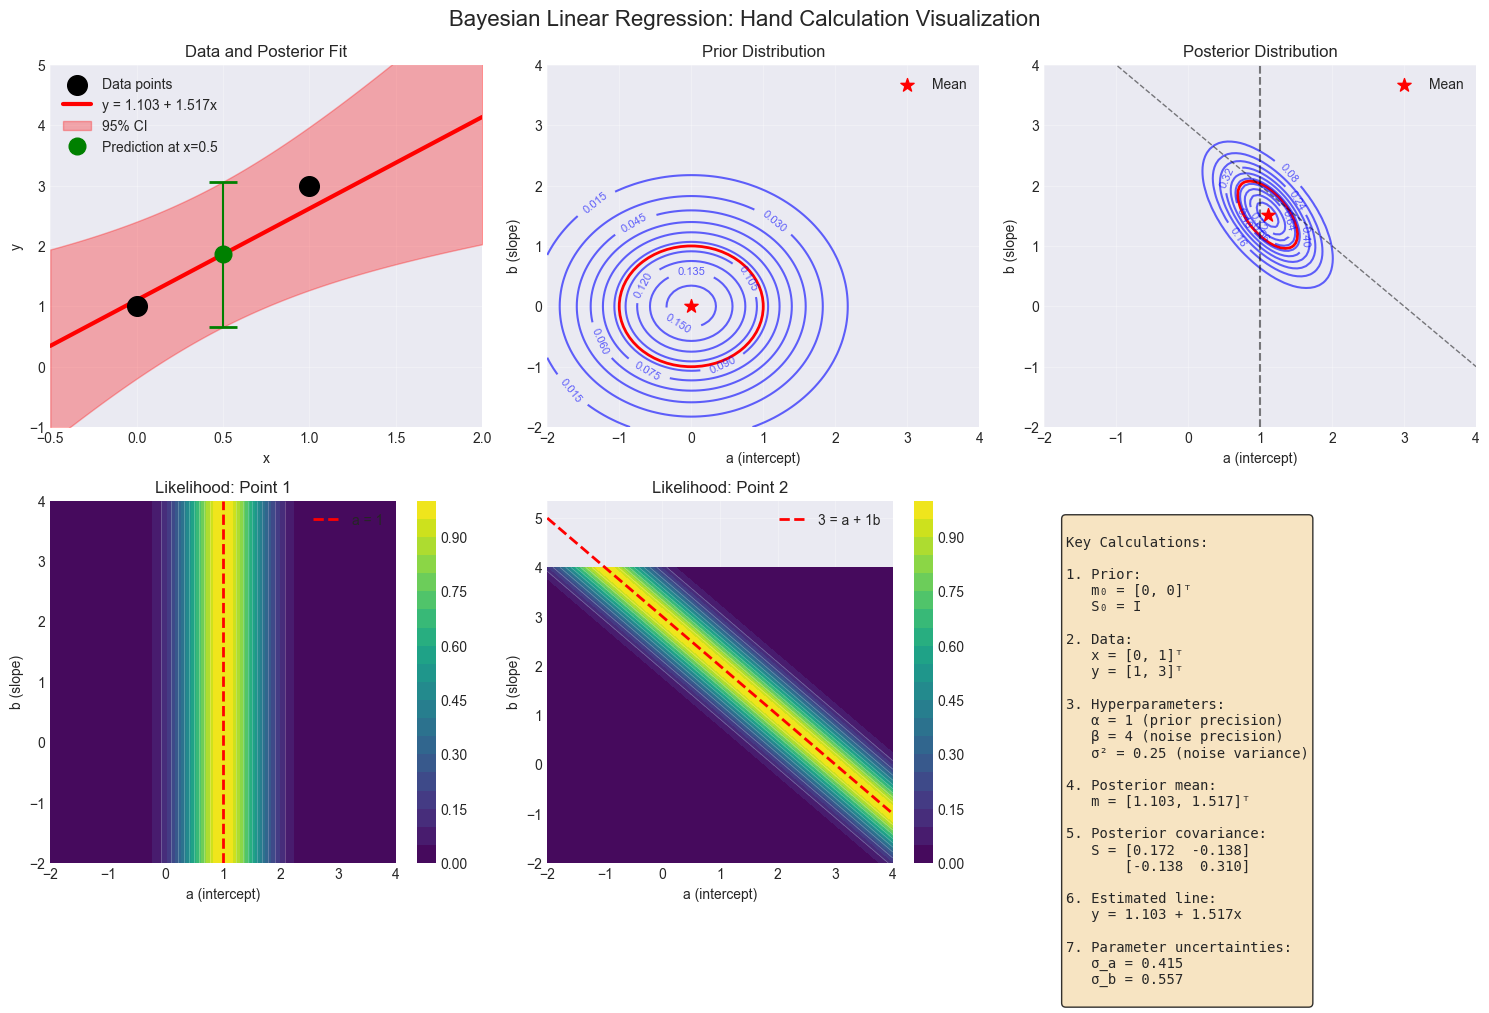

C:\Users\Petrb\AppData\Local\Temp\ipykernel_85792\3868670269.py:340: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Petrb\miniconda3\envs\02477_Bayes\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


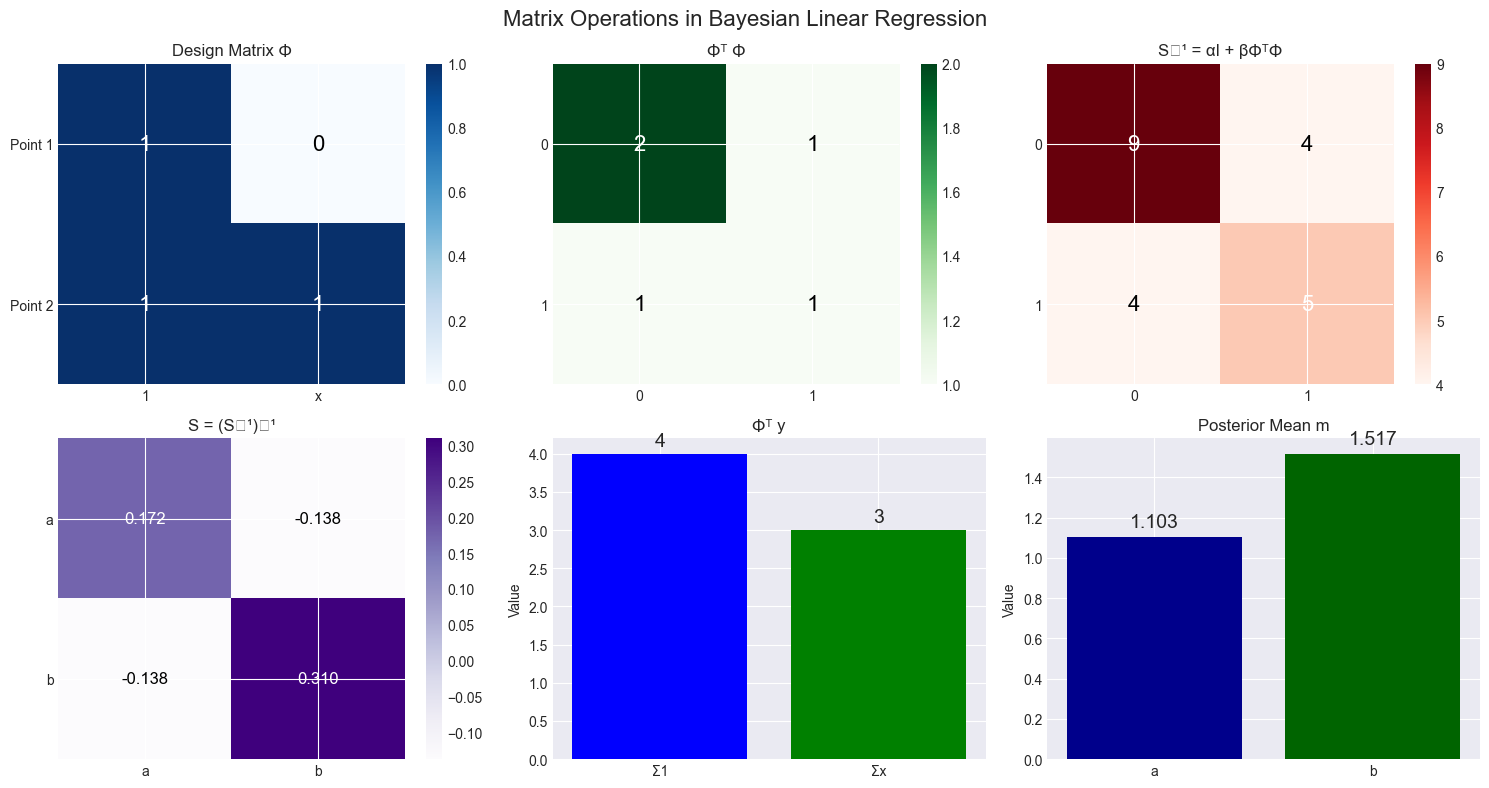

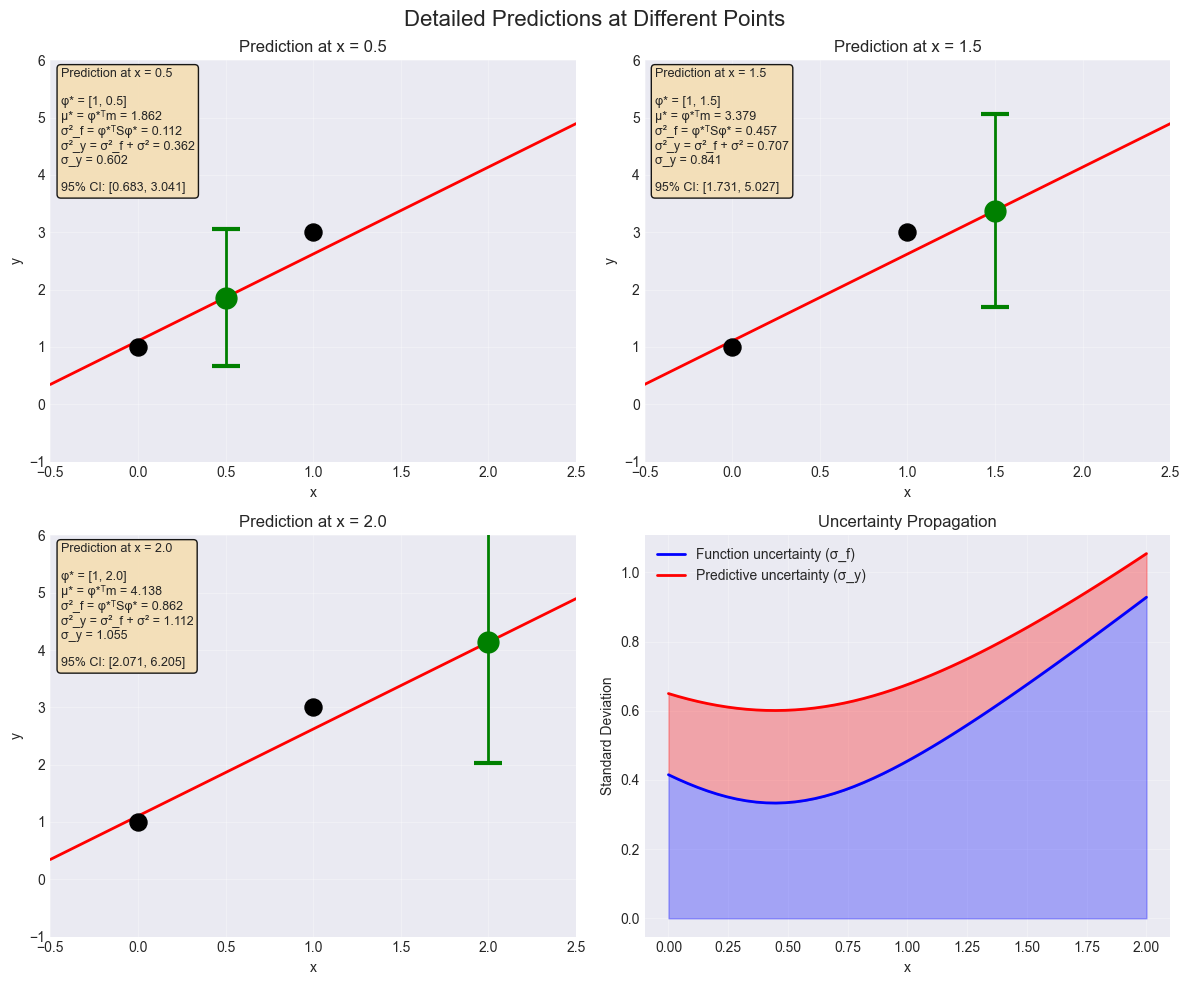

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, multivariate_normal

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def visualize_hand_calculation():
    """
    Visual companion to the hand calculation example
    """
    
    # Data from hand calculation
    x_data = np.array([0, 1])
    y_data = np.array([1, 3])
    
    # Hyperparameters
    alpha = 1.0
    beta = 4.0
    
    # Design matrix
    Phi = np.column_stack([np.ones_like(x_data), x_data])
    print("Design matrix Φ:")
    print(Phi)
    
    # Prior
    m0 = np.zeros(2)
    S0 = (1/alpha) * np.eye(2)
    S0_inv = alpha * np.eye(2)
    
    # Calculations from hand example
    PhiT_Phi = Phi.T @ Phi
    print("\nΦᵀΦ:")
    print(PhiT_Phi)
    
    S_inv = S0_inv + beta * PhiT_Phi
    print("\nS⁻¹ = S₀⁻¹ + βΦᵀΦ:")
    print(S_inv)
    
    S = np.linalg.inv(S_inv)
    print("\nPosterior covariance S:")
    print(S)
    
    PhiT_y = Phi.T @ y_data
    print("\nΦᵀy:")
    print(PhiT_y)
    
    m = S @ (S0_inv @ m0 + beta * PhiT_y)
    print("\nPosterior mean m:")
    print(m)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Data and fit
    ax1 = plt.subplot(2, 3, 1)
    x_plot = np.linspace(-0.5, 2, 100)
    Phi_plot = np.column_stack([np.ones_like(x_plot), x_plot])
    
    # Posterior mean prediction
    y_mean = Phi_plot @ m
    
    # Posterior variance
    var_f = np.diag(Phi_plot @ S @ Phi_plot.T)
    var_y = var_f + 1/beta
    std_y = np.sqrt(var_y)
    
    ax1.scatter(x_data, y_data, s=200, c='black', zorder=3, 
               label='Data points')
    ax1.plot(x_plot, y_mean, 'r-', linewidth=3, 
            label=f'y = {m[0]:.3f} + {m[1]:.3f}x')
    ax1.fill_between(x_plot, y_mean - 2*std_y, y_mean + 2*std_y,
                    alpha=0.3, color='red', label='95% CI')
    
    # Show prediction at x* = 0.5
    x_star = 0.5
    phi_star = np.array([1, x_star])
    y_star = phi_star @ m
    var_star = phi_star @ S @ phi_star + 1/beta
    
    ax1.plot([x_star], [y_star], 'go', markersize=12, 
            label=f'Prediction at x={x_star}')
    ax1.errorbar([x_star], [y_star], yerr=2*np.sqrt(var_star), 
                color='green', capsize=10, capthick=2)
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Data and Posterior Fit')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-0.5, 2)
    ax1.set_ylim(-1, 5)
    
    # 2. Prior in weight space
    ax2 = plt.subplot(2, 3, 2)
    plot_weight_distribution(ax2, m0, S0, 'Prior Distribution')
    
    # 3. Posterior in weight space
    ax3 = plt.subplot(2, 3, 3)
    plot_weight_distribution(ax3, m, S, 'Posterior Distribution')
    
    # Add data constraint lines
    for i in range(len(x_data)):
        a_range = np.linspace(-2, 4, 100)
        b_range = (y_data[i] - a_range) / x_data[i] if x_data[i] != 0 else None
        if b_range is not None:
            ax3.plot(a_range, b_range, 'k--', alpha=0.5, linewidth=1)
        else:
            ax3.axvline(y_data[i], color='k', linestyle='--', alpha=0.5)
    
    # 4. Likelihood for first data point
    ax4 = plt.subplot(2, 3, 4)
    plot_likelihood_single_point(ax4, x_data[0], y_data[0], beta, 
                               'Likelihood: Point 1')
    
    # 5. Likelihood for second data point
    ax5 = plt.subplot(2, 3, 5)
    plot_likelihood_single_point(ax5, x_data[1], y_data[1], beta,
                               'Likelihood: Point 2')
    
    # 6. Step-by-step calculation visualization
    ax6 = plt.subplot(2, 3, 6)
    show_calculation_steps(ax6, m, S)
    
    plt.tight_layout()
    plt.suptitle('Bayesian Linear Regression: Hand Calculation Visualization', 
                fontsize=16, y=1.02)
    plt.show()
    
    # Additional detailed plots
    plot_matrix_operations()
    plot_prediction_details(x_data, y_data, m, S, beta)


def plot_weight_distribution(ax, mean, cov, title):
    """Plot 2D Gaussian distribution in weight space"""
    # Create grid
    a_range = np.linspace(-2, 4, 100)
    b_range = np.linspace(-2, 4, 100)
    A, B = np.meshgrid(a_range, b_range)
    
    # Compute density
    rv = multivariate_normal(mean, cov)
    pos = np.dstack((A, B))
    density = rv.pdf(pos)
    
    # Plot contours
    contours = ax.contour(A, B, density, levels=10, colors='blue', alpha=0.6)
    ax.clabel(contours, inline=True, fontsize=8)
    
    # Plot mean
    ax.scatter([mean[0]], [mean[1]], c='red', s=100, marker='*', 
              zorder=3, label='Mean')
    
    # Plot covariance ellipse
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(eigenvalues)
    
    from matplotlib.patches import Ellipse
    ellipse = Ellipse(mean, width, height, angle=angle, 
                     facecolor='none', edgecolor='red', linewidth=2)
    ax.add_patch(ellipse)
    
    ax.set_xlabel('a (intercept)')
    ax.set_ylabel('b (slope)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2, 4)
    ax.set_ylim(-2, 4)
    ax.legend()


def plot_likelihood_single_point(ax, x, y, beta, title):
    """Plot likelihood function for a single data point"""
    # Create grid
    a_range = np.linspace(-2, 4, 50)
    b_range = np.linspace(-2, 4, 50)
    A, B = np.meshgrid(a_range, b_range)
    
    # Compute likelihood
    predicted = A + B * x
    likelihood = np.exp(-0.5 * beta * (y - predicted)**2)
    likelihood /= likelihood.max()  # Normalize for visualization
    
    # Plot
    contour = ax.contourf(A, B, likelihood, levels=20, cmap='viridis')
    ax.contour(A, B, likelihood, levels=10, colors='white', 
              alpha=0.3, linewidths=0.5)
    
    # Add constraint line
    constraint_b = (y - a_range) / x if x != 0 else None
    if constraint_b is not None:
        ax.plot(a_range, constraint_b, 'r--', linewidth=2, 
               label=f'{y} = a + {x}b')
    else:
        ax.axvline(y, color='r', linestyle='--', linewidth=2,
                  label=f'a = {y}')
    
    ax.set_xlabel('a (intercept)')
    ax.set_ylabel('b (slope)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.colorbar(contour, ax=ax)


def show_calculation_steps(ax, m, S):
    """Show key calculation results"""
    ax.axis('off')
    
    text = f"""
Key Calculations:

1. Prior:
   m₀ = [0, 0]ᵀ
   S₀ = I

2. Data:
   x = [0, 1]ᵀ
   y = [1, 3]ᵀ

3. Hyperparameters:
   α = 1 (prior precision)
   β = 4 (noise precision)
   σ² = 0.25 (noise variance)

4. Posterior mean:
   m = [{m[0]:.3f}, {m[1]:.3f}]ᵀ
   
5. Posterior covariance:
   S = [{S[0,0]:.3f}  {S[0,1]:.3f}]
       [{S[1,0]:.3f}  {S[1,1]:.3f}]

6. Estimated line:
   y = {m[0]:.3f} + {m[1]:.3f}x

7. Parameter uncertainties:
   σ_a = {np.sqrt(S[0,0]):.3f}
   σ_b = {np.sqrt(S[1,1]):.3f}
"""
    
    ax.text(0.05, 0.95, text, transform=ax.transAxes, 
           fontsize=10, verticalalignment='top',
           fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))


def plot_matrix_operations():
    """Visualize the matrix operations"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Define matrices
    Phi = np.array([[1, 0], [1, 1]])
    S0 = np.eye(2)
    alpha = 1
    beta = 4
    
    # Step 1: Design matrix
    ax = axes[0, 0]
    im = ax.imshow(Phi, cmap='Blues', aspect='auto')
    ax.set_title('Design Matrix Φ')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f'{Phi[i,j]:.0f}', ha='center', va='center',
                   color='white' if Phi[i,j] > 0.5 else 'black', fontsize=16)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['1', 'x'])
    ax.set_yticklabels(['Point 1', 'Point 2'])
    plt.colorbar(im, ax=ax)
    
    # Step 2: Φᵀ Φ
    PhiT_Phi = Phi.T @ Phi
    ax = axes[0, 1]
    im = ax.imshow(PhiT_Phi, cmap='Greens', aspect='auto')
    ax.set_title('Φᵀ Φ')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f'{PhiT_Phi[i,j]:.0f}', ha='center', va='center',
                   color='white' if PhiT_Phi[i,j] > 1 else 'black', fontsize=16)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    plt.colorbar(im, ax=ax)
    
    # Step 3: S⁻¹
    S_inv = S0 * alpha + beta * PhiT_Phi
    ax = axes[0, 2]
    im = ax.imshow(S_inv, cmap='Reds', aspect='auto')
    ax.set_title('S⁻¹ = αI + βΦᵀΦ')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f'{S_inv[i,j]:.0f}', ha='center', va='center',
                   color='white' if S_inv[i,j] > 4 else 'black', fontsize=16)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    plt.colorbar(im, ax=ax)
    
    # Step 4: S (posterior covariance)
    S = np.linalg.inv(S_inv)
    ax = axes[1, 0]
    im = ax.imshow(S, cmap='Purples', aspect='auto')
    ax.set_title('S = (S⁻¹)⁻¹')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f'{S[i,j]:.3f}', ha='center', va='center',
                   color='white' if abs(S[i,j]) > 0.15 else 'black', fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['a', 'b'])
    ax.set_yticklabels(['a', 'b'])
    plt.colorbar(im, ax=ax)
    
    # Step 5: Φᵀ y
    y = np.array([1, 3])
    PhiT_y = Phi.T @ y
    ax = axes[1, 1]
    ax.bar([0, 1], PhiT_y, color=['blue', 'green'])
    ax.set_title('Φᵀ y')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Σ1', 'Σx'])
    ax.set_ylabel('Value')
    for i, v in enumerate(PhiT_y):
        ax.text(i, v + 0.1, f'{v:.0f}', ha='center', fontsize=14)
    
    # Step 6: Final posterior mean
    m = S @ (beta * PhiT_y)
    ax = axes[1, 2]
    ax.bar([0, 1], m, color=['darkblue', 'darkgreen'])
    ax.set_title('Posterior Mean m')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['a', 'b'])
    ax.set_ylabel('Value')
    for i, v in enumerate(m):
        ax.text(i, v + 0.05, f'{v:.3f}', ha='center', fontsize=14)
    
    plt.suptitle('Matrix Operations in Bayesian Linear Regression', fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_prediction_details(x_data, y_data, m, S, beta):
    """Detailed prediction visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Prediction at multiple points
    x_pred = np.array([0.5, 1.5, 2.0])
    
    for idx, x_star in enumerate(x_pred):
        ax = axes[idx // 2, idx % 2]
        
        # Compute prediction
        phi_star = np.array([1, x_star])
        mu_star = phi_star @ m
        var_f_star = phi_star @ S @ phi_star
        var_y_star = var_f_star + 1/beta
        std_y_star = np.sqrt(var_y_star)
        
        # Plot data and fit
        x_plot = np.linspace(-0.5, 2.5, 100)
        Phi_plot = np.column_stack([np.ones_like(x_plot), x_plot])
        y_mean = Phi_plot @ m
        
        ax.scatter(x_data, y_data, s=150, c='black', zorder=3)
        ax.plot(x_plot, y_mean, 'r-', linewidth=2)
        
        # Highlight prediction point
        ax.plot([x_star], [mu_star], 'go', markersize=15)
        ax.errorbar([x_star], [mu_star], yerr=2*std_y_star,
                   color='green', capsize=10, capthick=3, linewidth=2)
        
        # Add text box with details
        text = f"""Prediction at x = {x_star}
        
φ* = [{phi_star[0]:.0f}, {phi_star[1]:.1f}]
μ* = φ*ᵀm = {mu_star:.3f}
σ²_f = φ*ᵀSφ* = {var_f_star:.3f}
σ²_y = σ²_f + σ² = {var_y_star:.3f}
σ_y = {std_y_star:.3f}

95% CI: [{mu_star-1.96*std_y_star:.3f}, {mu_star+1.96*std_y_star:.3f}]"""
        
        ax.text(0.02, 0.98, text, transform=ax.transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9),
               fontsize=9)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Prediction at x = {x_star}')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(-1, 6)
    
    # Last subplot: show uncertainty propagation
    ax = axes[1, 1]
    x_range = np.linspace(0, 2, 50)
    var_f_range = []
    var_y_range = []
    
    for x in x_range:
        phi = np.array([1, x])
        var_f = phi @ S @ phi
        var_y = var_f + 1/beta
        var_f_range.append(var_f)
        var_y_range.append(var_y)
    
    ax.plot(x_range, np.sqrt(var_f_range), 'b-', linewidth=2, 
           label='Function uncertainty (σ_f)')
    ax.plot(x_range, np.sqrt(var_y_range), 'r-', linewidth=2,
           label='Predictive uncertainty (σ_y)')
    ax.fill_between(x_range, 0, np.sqrt(var_f_range), alpha=0.3, color='blue')
    ax.fill_between(x_range, np.sqrt(var_f_range), np.sqrt(var_y_range), 
                   alpha=0.3, color='red')
    
    ax.set_xlabel('x')
    ax.set_ylabel('Standard Deviation')
    ax.set_title('Uncertainty Propagation')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Detailed Predictions at Different Points', fontsize=16)
    plt.tight_layout()
    plt.show()


# Run the visualization
if __name__ == "__main__":
    print("Bayesian Linear Regression: Hand Calculation Visualization")
    print("=" * 50)
    visualize_hand_calculation()